Install Required Packages!!

In [ ]:
!pip install --upgrade pip
!pip install torch transformers numpy matplotlib networkx scikit-learn

Imports and Setup

In [ ]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import networkx as nx
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score

from transformers import AutoTokenizer, AutoModel

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


Tiny multilingual dataset represented as dependency graphs with semantic role/frames

In [ ]:
def make_example(lang, tokens, edges, frame_label, node_roles=None):
    return {
        'lang': lang,                  # 'de'|'es'|'el'
        'tokens': tokens,              # list of tokens (space-split)
        'edges': edges,                # list of (head_idx, dep_idx, dep_rel)
        'frame_label': frame_label,    # string frame
        'node_roles': node_roles or ['O']*len(tokens)
    }

dataset = [
    # Eating
    make_example('de', ["Der","Mann","isst","einen","Apfel"],
                 edges=[(2,0,'det'), (2,1,'nsubj'), (2,3,'obj'), (3,4,'compound')],
                 frame_label='Eating', node_roles=['O','Agent','Predicate','O','Theme']),
    make_example('es', ["La","mujer","come","una","manzana"],
                 edges=[(2,0,'det'), (2,1,'nsubj'), (2,3,'obj'), (3,4,'compound')],
                 frame_label='Eating', node_roles=['O','Agent','Predicate','O','Theme']),
    make_example('el', ["Ο","άντρας","τρώει","μήλο"],
                 edges=[(2,0,'det'), (2,1,'nsubj'), (2,2,'root'), (2,3,'obj')],
                 frame_label='Eating', node_roles=['O','Agent','Predicate','Theme']),

    # Destruction
    make_example('de', ["Das","Feuer","zerstörte","das","Haus"],
                 edges=[(2,0,'det'), (2,1,'nsubj'), (2,3,'det'), (2,4,'obj')],
                 frame_label='Destruction', node_roles=['O','Agent','Predicate','O','Theme']),
    make_example('es', ["El","incendio","destruyó","la","casa"],
                 edges=[(2,0,'det'), (2,1,'nsubj'), (2,3,'det'), (2,4,'obj')],
                 frame_label='Destruction', node_roles=['O','Agent','Predicate','O','Theme']),
    make_example('el', ["Η","φωτιά","κατέστρεψε","το","σπίτι"],
                 edges=[(2,0,'det'), (2,1,'nsubj'), (2,3,'det'), (2,4,'obj')],
                 frame_label='Destruction', node_roles=['O','Agent','Predicate','O','Theme']),

    # Transfer (add a third frame to make metrics more meaningful)
    make_example('de', ["Die","Frau","gibt","dem","Kind","das","Buch"],
                 edges=[(2,0,'det'),(2,1,'nsubj'),(2,3,'iobj'),(2,4,'iobj'),(2,5,'det'),(2,6,'obj')],
                 frame_label='Transfer', node_roles=['O','Agent','Predicate','O','Recipient','O','Theme']),
    make_example('es', ["La","mujer","da","al","niño","el","libro"],
                 edges=[(2,0,'det'),(2,1,'nsubj'),(2,3,'iobj'),(3,4,'compound'),(2,5,'det'),(2,6,'obj')],
                 frame_label='Transfer', node_roles=['O','Agent','Predicate','O','Recipient','O','Theme']),
    make_example('el', ["Η","γυναίκα","δίνει","στο","παιδί","το","βιβλίο"],
                 edges=[(2,0,'det'),(2,1,'nsubj'),(2,3,'iobj'),(3,4,'compound'),(2,5,'det'),(2,6,'obj')],
                 frame_label='Transfer', node_roles=['O','Agent','Predicate','O','Recipient','O','Theme']),
]

frame_encoder = LabelEncoder().fit([ex['frame_label'] for ex in dataset])
role_encoder  = LabelEncoder().fit([r for ex in dataset for r in ex['node_roles']])

print("Frames:", list(frame_encoder.classes_))
print("Roles:", list(role_encoder.classes_))
print("Examples:", len(dataset))


Frames: [np.str_('Destruction'), np.str_('Eating'), np.str_('Transfer')]
Roles: [np.str_('Agent'), np.str_('O'), np.str_('Predicate'), np.str_('Recipient'), np.str_('Theme')]
Examples: 9


Load XLM-R for multilingual embeddings

In [ ]:
MODEL_NAME = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
xlmr = AutoModel.from_pretrained(MODEL_NAME)
xlmr.to(device)
xlmr.eval()

# Freeze to keep training light; flip to True if you want to fine-tune, frozen by default
for p in xlmr.parameters():
    p.requires_grad = False

EMB_DIM_XLMR = xlmr.config.hidden_size  # 768
print("XLM-R hidden size:", EMB_DIM_XLMR)


Helper to get embeddings and positional embeddings from tree distances

In [ ]:
import torch
from collections import deque

lang_to_id = {'de':0, 'es':1, 'el':2}

def tokens_to_embeddings(tokens):
    enc = tokenizer(tokens, is_split_into_words=True, return_tensors="pt", padding=True, truncation=True, add_special_tokens=True)
    enc = {k: v.to(device) for k,v in enc.items()}
    with torch.no_grad():
        out = xlmr(**enc).last_hidden_state.squeeze(0)
    word_ids = tokenizer(tokens, is_split_into_words=True).word_ids()
    n_words = len(tokens)
    reps = torch.zeros(n_words, out.size(-1), device=device)
    counts = torch.zeros(n_words, device=device)
    for i, wid in enumerate(word_ids):
        if wid is not None:
            reps[wid] += out[i]
            counts[wid] += 1
    counts = counts.clamp(min=1.0).unsqueeze(-1)
    reps = reps / counts
    return reps  # [n, hidden]

def compute_tree_distances(n, edges):
    # BFS shortest path distances on undirected version of dependency tree
    G = [[] for _ in range(n)]
    for h,d,_ in edges:
        G[h].append(d)
        G[d].append(h)
    dmat = np.full((n,n), fill_value=999, dtype=np.int64)
    for i in range(n):
        dmat[i,i] = 0
        q = deque([i])
        while q:
            u = q.popleft()
            for v in G[u]:
                if dmat[i,v] > dmat[i,u]+1:
                    dmat[i,v] = dmat[i,u]+1
                    q.append(v)
    return dmat

def graph_to_tensors(example):
    tokens = example['tokens']
    X = tokens_to_embeddings(tokens)  # [n,768]
    edges = []
    edge_type_map = {}
    for (h,d,typ) in example['edges']:
        if typ not in edge_type_map:
            edge_type_map[typ] = len(edge_type_map)
        t = edge_type_map[typ]
        edges.append((h,d,t))
        edges.append((d,h,t+100))
    n = len(tokens)
    dmat = compute_tree_distances(n, example['edges'])  # [n,n]
    return {
        'X': X,
        'edges': [(int(a),int(b),int(c)) for (a,b,c) in edges],
        'lang_id': lang_to_id[example['lang']],
        'frame_label': int(frame_encoder.transform([example['frame_label']])[0]),
        'node_roles': torch.tensor(role_encoder.transform(example['node_roles']), dtype=torch.long, device=device),
        'distances': torch.tensor(dmat, dtype=torch.long, device=device)
    }

tensors = [graph_to_tensors(ex) for ex in dataset]
print("Prepared", len(tensors), "graphs with tree distances + embeddings.")


Prepared 9 graphs with tree distances + embeddings.


LieGNN with tree-distance embeddings added

In [ ]:
class SOAction(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.params = nn.Parameter(torch.randn(d, d) * 0.01)
    def forward(self):
        S = self.params - self.params.t()
        return torch.matrix_exp(S)

class LieGNNLayer(nn.Module):
    def __init__(self, d, capacity=256):
        super().__init__()
        self.actions = nn.ModuleList([SOAction(d) for _ in range(capacity)])
        self.msg_mlp = nn.Sequential(nn.Linear(d, d), nn.ReLU(), nn.Linear(d, d))
        self.update_mlp = nn.Sequential(nn.Linear(2*d, d), nn.ReLU(), nn.Linear(d, d))        # don't wanna be alone!
    def forward(self, X, edges):
        msg = torch.zeros_like(X)
        for (src, dst, e_type) in edges:
            R = self.actions[e_type % len(self.actions)]()
            m = self.msg_mlp(R @ X[src])
            msg[dst] += m
        return self.update_mlp(torch.cat([X, msg], dim=-1))

class LieGNN(nn.Module):
    def __init__(self, in_dim, d=128, n_layers=3, n_frames=3, n_roles=5, max_dist=10, dist_dim=32):
        super().__init__()
        self.proj = nn.Linear(in_dim, d)
        self.dist_emb = nn.Embedding(max_dist+1, dist_dim)  # positional encoding for distances
        self.dist_proj = nn.Linear(d+dist_dim, d)
        self.layers = nn.ModuleList([LieGNNLayer(d) for _ in range(n_layers)])
        self.node_cls = nn.Linear(d, n_roles)
        self.sent_mlp = nn.Sequential(nn.Linear(d, d), nn.ReLU(), nn.Linear(d, n_frames))

    def forward(self, X, edges, dist_mat=None):
        H = F.relu(self.proj(X))
        # Add distance-based encodings: each node gets its avg distance embedding to all others
        if dist_mat is not None:
            dist_clip = dist_mat.clamp(max=self.dist_emb.num_embeddings-1)
            dist_embs = self.dist_emb(dist_clip)  # [n,n,dim]
            node_dist = dist_embs.mean(dim=1)     # average distances to all nodes
            H = self.dist_proj(torch.cat([H, node_dist], dim=-1))
        for layer in self.layers:
            H = H + layer(H, edges)
        node_logits = self.node_cls(H)
        sent_logits = self.sent_mlp(H.mean(dim=0))
        return node_logits, sent_logits, H


Training with contrastive loss acroos aligned sentences

In [ ]:
n_frames = len(frame_encoder.classes_)
n_roles  = len(role_encoder.classes_)
model = LieGNN(in_dim=EMB_DIM_XLMR, d=128, n_layers=3, n_frames=n_frames, n_roles=n_roles).to(device)

optimizer = Adam(model.parameters(), lr=2e-3, weight_decay=1e-4)
loss_node = nn.CrossEntropyLoss()
loss_sent = nn.CrossEntropyLoss()

def contrastive_loss(reps, labels, temperature=0.1):
    """
    reps: [B, d] sentence representations
    labels: [B] frame ids
    InfoNCE: positives are pairs with same frame id
    """
    reps = F.normalize(reps, dim=-1)
    sim = reps @ reps.t() / temperature  # [B,B]
    mask = torch.eye(len(labels), device=reps.device).bool()
    sim = sim.masked_fill(mask, -1e9)
    labels = labels.unsqueeze(0)
    pos_mask = (labels.T == labels)
    loss = []
    for i in range(len(labels[0])):
        logits = sim[i]
        targets = pos_mask[i].float()
        if targets.sum() > 0:
            log_probs = F.log_softmax(logits, dim=-1)
            pos_log_probs = (log_probs * targets).sum() / targets.sum()
            loss.append(-pos_log_probs)
    return torch.stack(loss).mean() if loss else torch.tensor(0.0, device=reps.device)

def train(model, tensors, epochs=80, log_every=10, lambda_con=0.3):
    for ep in range(1, epochs+1):
        model.train()
        total = 0.0
        for t in tensors:
            nl, sl, H = model(t['X'], t['edges'], t['distances'])
            loss_r = loss_node(nl, t['node_roles'])
            loss_f = loss_sent(sl.unsqueeze(0), torch.tensor([t['frame_label']], device=device))
            # sentence repr for contrastive
            s_repr = H.mean(dim=0, keepdim=True)
            loss = loss_r + 0.8*loss_f
            # accumulate grads
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total += loss.item()

        # batch-level contrastive after epoch (all sentences together)
        model.eval()
        reps, labs = [], []
        with torch.no_grad():
            for t in tensors:
                _, _, H = model(t['X'], t['edges'], t['distances'])
                reps.append(H.mean(dim=0))
                labs.append(t['frame_label'])
        reps = torch.stack(reps)
        labs = torch.tensor(labs, device=device)
        loss_c = contrastive_loss(reps, labs)
        # one more backward/opt step
        optimizer.zero_grad()
        (lambda_con*loss_c).backward()
        optimizer.step()

        if ep % log_every == 0 or ep == 1:
            print(f"Epoch {ep:03d} | loss={total/len(tensors):.4f} contrastive={loss_c.item():.4f}")


Evaluation with cross-lingual alignment quality

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from collections import defaultdict

def evaluate(model, tensors):
    model.eval()
    all_roles_true, all_roles_pred = [], []
    all_frames_true, all_frames_pred = [], []
    sent_reps, sent_frames, sent_langs = [], [], []

    with torch.no_grad():
        for t in tensors:
            node_logits, frame_logits, H = model(t['X'], t['edges'], t['distances'])
            role_pred = node_logits.argmax(-1).cpu().numpy()
            all_roles_true.extend(t['node_roles'].cpu().numpy())
            all_roles_pred.extend(role_pred)

            frame_pred = frame_logits.argmax().item()
            all_frames_true.append(t['frame_label'])
            all_frames_pred.append(frame_pred)

            sent_reps.append(H.mean(dim=0).cpu())
            sent_frames.append(t['frame_label'])
            sent_langs.append(t['lang_id'])

    # role metrics
    role_acc = accuracy_score(all_roles_true, all_roles_pred)
    role_f1_micro = f1_score(all_roles_true, all_roles_pred, average='micro')
    role_f1_macro = f1_score(all_roles_true, all_roles_pred, average='macro')

    # frame metrics
    frame_acc = accuracy_score(all_frames_true, all_frames_pred)
    frame_f1_micro = f1_score(all_frames_true, all_frames_pred, average='micro')
    frame_f1_macro = f1_score(all_frames_true, all_frames_pred, average='macro')

    # cross-lingual retrieval
    reps = torch.stack(sent_reps)  # [N, d]
    reps = F.normalize(reps, dim=-1)
    langs = torch.tensor(sent_langs)
    frames = torch.tensor(sent_frames)

    retrieval_scores = []
    for i in range(len(reps)):
        # find candidates with same frame, different language
        mask = (frames == frames[i]) & (langs != langs[i])
        if mask.sum() == 0:
            continue
        sims = reps[i] @ reps.T
        sims[i] = -1e9  # exclude self
        best = sims.argmax().item()
        retrieval_scores.append(int(frames[best] == frames[i]))

    align_acc = np.mean(retrieval_scores) if retrieval_scores else 0.0

    return {
        "role_acc": role_acc,
        "role_f1_micro": role_f1_micro,
        "role_f1_macro": role_f1_macro,
        "frame_acc": frame_acc,
        "frame_f1_micro": frame_f1_micro,
        "frame_f1_macro": frame_f1_macro,
        "crosslingual_retrieval_acc": align_acc
    }

# Example after training:
metrics = evaluate(model, tensors)
for k,v in metrics.items():
    print(f"{k:25s} {v:.4f}")


role_acc                  0.4600
role_f1_micro             0.4600
role_f1_macro             0.2109
frame_acc                 0.2222
frame_f1_micro            0.2222
frame_f1_macro            0.1212
crosslingual_retrieval_acc 0.7778


Dependency graphs annotated with predicted roles and frames

Example 0 | lang=de | gold=Eating | pred=Transfer


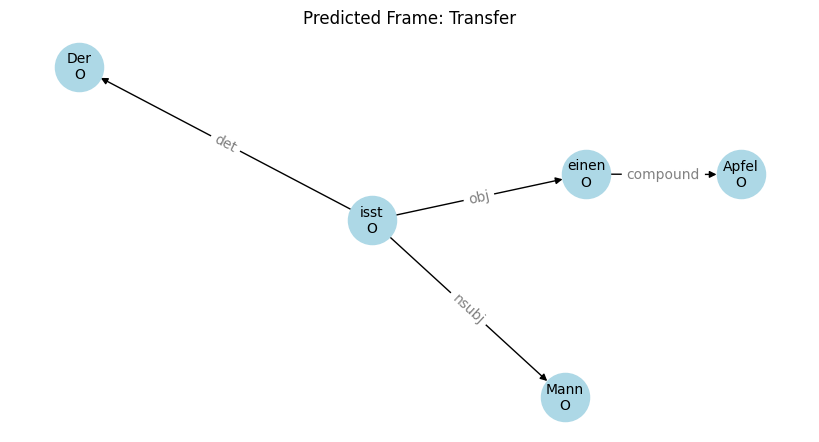

Example 1 | lang=es | gold=Eating | pred=Transfer


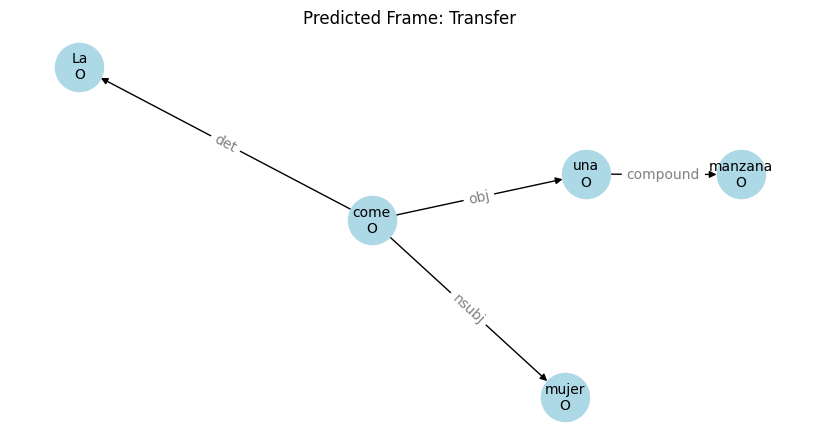

Example 2 | lang=el | gold=Eating | pred=Transfer


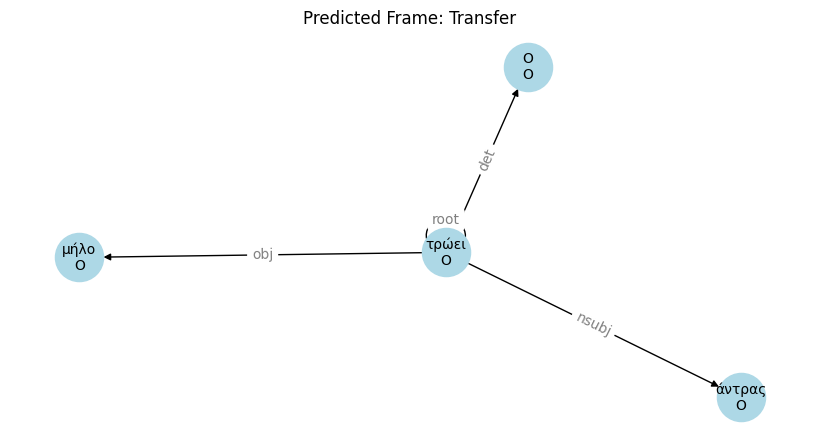

Example 3 | lang=de | gold=Destruction | pred=Transfer


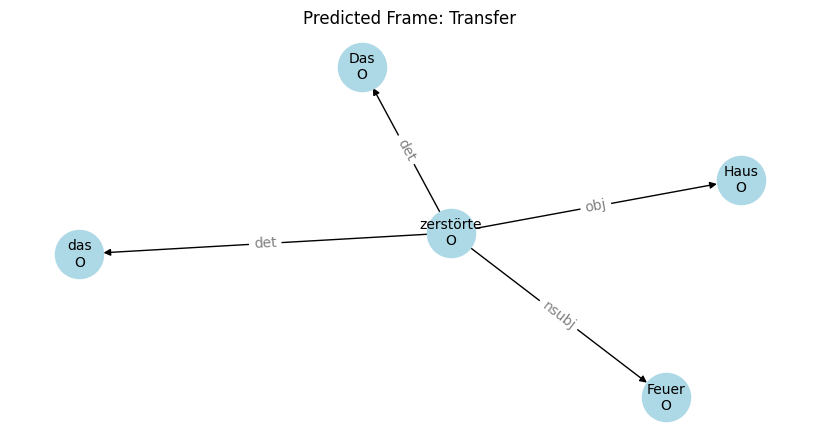

Example 4 | lang=es | gold=Destruction | pred=Transfer


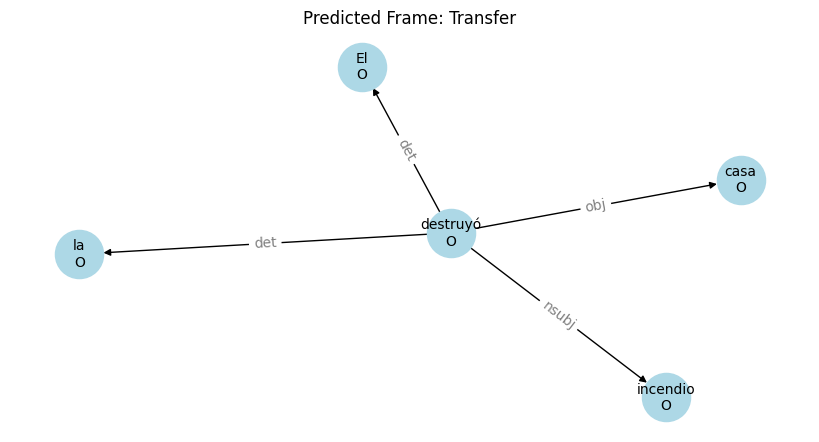

Example 5 | lang=el | gold=Destruction | pred=Transfer


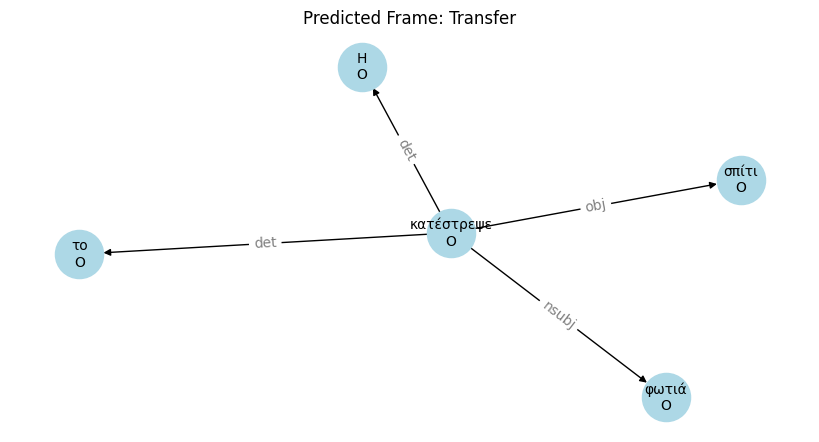

Example 6 | lang=de | gold=Transfer | pred=Transfer


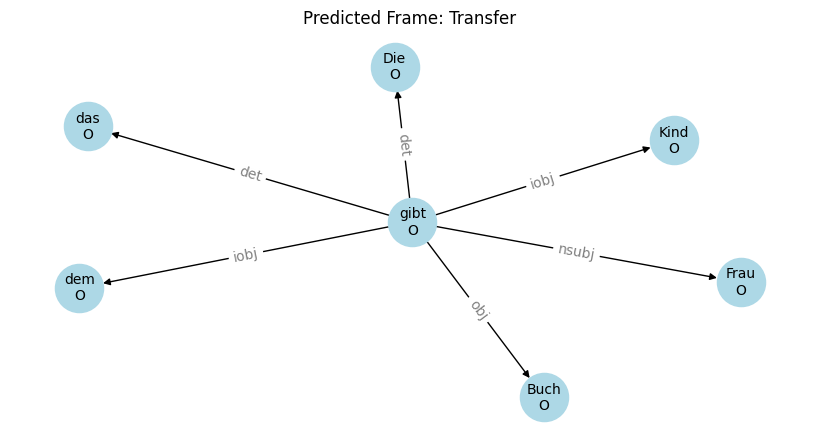

Example 7 | lang=es | gold=Transfer | pred=Transfer


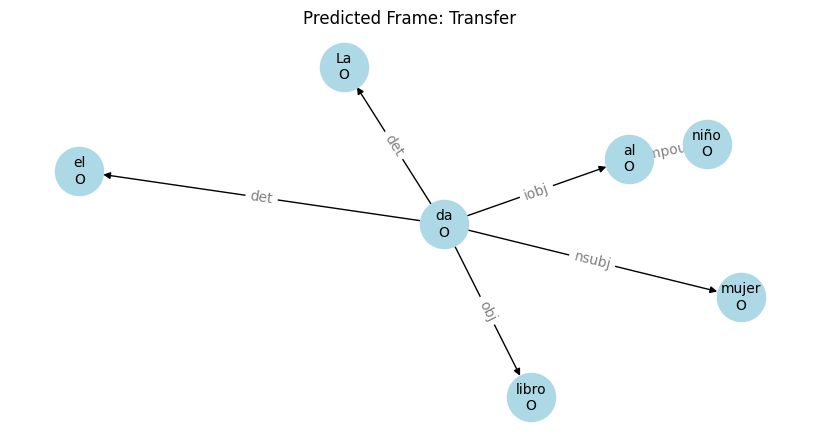

Example 8 | lang=el | gold=Transfer | pred=Transfer


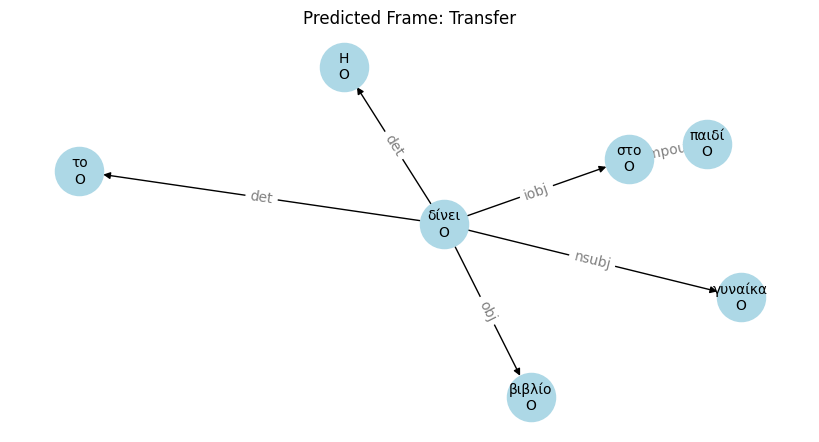

In [ ]:
def visualize_graph(example, node_preds=None, title=None):
    tokens = example['tokens']
    G = nx.DiGraph()
    G.add_nodes_from(range(len(tokens)))
    for (h,d,typ) in example['edges']:
        G.add_edge(h, d, label=typ)
    pos = nx.spring_layout(G, seed=SEED)
    plt.figure(figsize=(8,4))
    nx.draw(G, pos, with_labels=False, arrows=True, node_color='lightblue', node_size=1200)
    node_labels = {}
    for i, tok in enumerate(tokens):
        role = ''
        if node_preds is not None:
            role = role_encoder.inverse_transform([int(node_preds[i])])[0]
        node_labels[i] = f"{tok}\n{role}"
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)
    edge_labels = {(u,v): G.edges[u,v]['label'] for u,v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='gray')
    if title: plt.title(title)
    plt.axis('off')
    plt.show()

model.eval()
with torch.no_grad():
    for i, ex in enumerate(dataset):
        t = tensors[i]
        nl, sl, _ = model(t['X'], t['edges'])
        node_pred = nl.argmax(dim=-1).detach().cpu().numpy()
        frame_pred = frame_encoder.inverse_transform([int(sl.argmax().detach().cpu().numpy())])[0]
        print(f"Example {i} | lang={ex['lang']} | gold={ex['frame_label']} | pred={frame_pred}")
        visualize_graph(ex, node_pred, title=f"Predicted Frame: {frame_pred}")


UMAP visualization of sentence embeddings

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


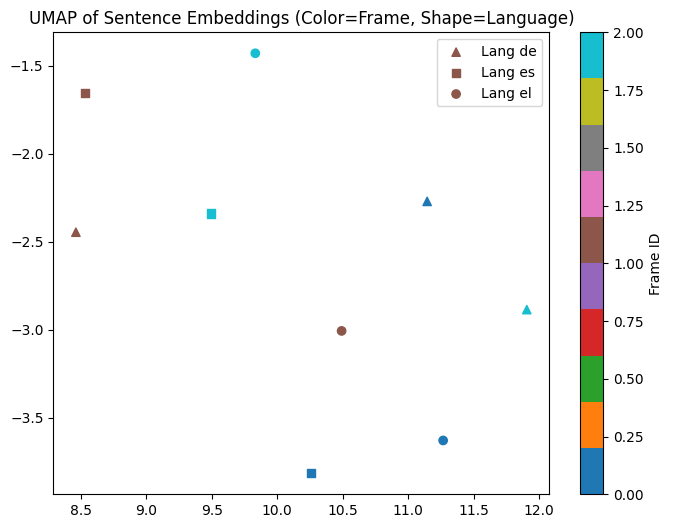

In [ ]:
import matplotlib.pyplot as plt
import umap.umap_ as umap

def visualize_embeddings(model, tensors):
    model.eval()
    sent_reps, sent_frames, sent_langs = [], [], []
    with torch.no_grad():
        for t in tensors:
            _, _, H = model(t['X'], t['edges'], t['distances'])
            sent_reps.append(H.mean(dim=0).cpu().numpy())
            sent_frames.append(t['frame_label'])
            sent_langs.append(t['lang_id'])

    reps = np.stack(sent_reps)
    reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=42)
    emb_2d = reducer.fit_transform(reps)

    frame_names = frame_encoder.inverse_transform(list(set(sent_frames)))
    lang_names = {0:"de", 1:"es", 2:"el"}

    plt.figure(figsize=(8,6))
    for lang_id in np.unique(sent_langs):
        idx = [i for i,l in enumerate(sent_langs) if l == lang_id]
        plt.scatter(
            emb_2d[idx,0], emb_2d[idx,1],
            c=[sent_frames[i] for i in idx],
            cmap="tab10", marker="^" if lang_id==0 else "s" if lang_id==1 else "o",
            label=f"Lang {lang_names[lang_id]}"
        )

    cbar = plt.colorbar()
    cbar.set_label("Frame ID")
    plt.legend()
    plt.title("UMAP of Sentence Embeddings (Color=Frame, Shape=Language)")
    plt.show()

# Example usage after training
visualize_embeddings(model, tensors)


Simple cross-lingual aligment probe

In [ ]:
# measure cosine similarity of pooled sentence representations across languages for the same frame.
def sentence_repr(model, X, edges):
    with torch.no_grad():
        _, _, H = model(X, edges)
    return H.mean(dim=0).detach().cpu().numpy()

by_frame = {}
for ex, t in zip(dataset, tensors):
    rep = sentence_repr(model, t['X'], t['edges'])
    by_frame.setdefault(ex['frame_label'], []).append((ex['lang'], rep))

from sklearn.metrics.pairwise import cosine_similarity
for frame, items in by_frame.items():
    mats = np.stack([r for _, r in items], axis=0)
    sims = cosine_similarity(mats)
    langs = [l for l,_ in items]
    print(f"\nFrame: {frame}")
    print("Langs:", langs)
    print("Cosine similarity matrix:")
    print(np.round(sims, 3))



Frame: Eating
Langs: ['de', 'es', 'el']
Cosine similarity matrix:
[[1.    0.993 0.992]
 [0.993 1.    0.996]
 [0.992 0.996 1.   ]]

Frame: Destruction
Langs: ['de', 'es', 'el']
Cosine similarity matrix:
[[1.    0.996 0.996]
 [0.996 1.    0.996]
 [0.996 0.996 1.   ]]

Frame: Transfer
Langs: ['de', 'es', 'el']
Cosine similarity matrix:
[[1.    0.994 0.996]
 [0.994 1.    0.996]
 [0.996 0.996 1.   ]]
